# Product Analysis (EDA)

This notebook focuses on understanding product using cleaned retail transaction data.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
df = df[df['IsCancellation'] != True]

### 1. Revenue vs Quantity Sold

In [32]:
# Question: How to calculate total quantity sold and revenue per product?
product_df = df.groupby(['StockCode']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

product_df.rename(columns={'TotalPrice': 'Revenue'}, inplace=True)
product_df


,StockCode,Quantity,Revenue
0,10002,1037,759.89
1,10080,495,119.09
2,10120,192,40.32
3,10123C,-13,3.25
4,10123G,-38,0.00
...,...,...,...
4054,gift_0001_20,20,167.05
4055,gift_0001_30,37,175.53
4056,gift_0001_40,3,100.70
4057,gift_0001_50,4,167.56


In [33]:
# Question: Which products are top revenue generators and top sellers?
top_revenue_products = product_df.sort_values(by='Revenue', ascending=False).head(10)
top_quantity_products = product_df.sort_values(by='Quantity', ascending=False).head(10)

print("Top 10 Products by Revenue:")
#print(top_revenue_products[['StockCode','Description','Revenue','Quantity']])
print(top_revenue_products[['StockCode','Revenue','Quantity']])

print("\nTop 10 Products by Quantity Sold:")
print(top_quantity_products[['StockCode','Revenue','Quantity']])

Top 10 Products by Revenue:
     StockCode    Revenue  Quantity
4048       DOT  206248.77      1708
1347     22423  174156.54     13809
2505     23843  168469.60     80995
3527    85123A  104462.75     41389
2730     47566   99445.23     18287
3506    85099B   94159.81     48375
2059     23166   81700.92     78033
4051      POST   78101.88      6500
4049         M   77750.27      6990
1981     23084   66870.03     30705

Top 10 Products by Quantity Sold:
     StockCode    Revenue  Quantity
2505     23843  168469.60     80995
2059     23166   81700.92     78033
1146     22197   51334.47     56898
2993     84077   13814.01     54951
3506    85099B   94159.81     48375
3527    85123A  104462.75     41389
453      21212   21246.45     36396
3300     84879   58927.62     36202
1981     23084   66870.03     30705
1411     22492   16937.82     26633


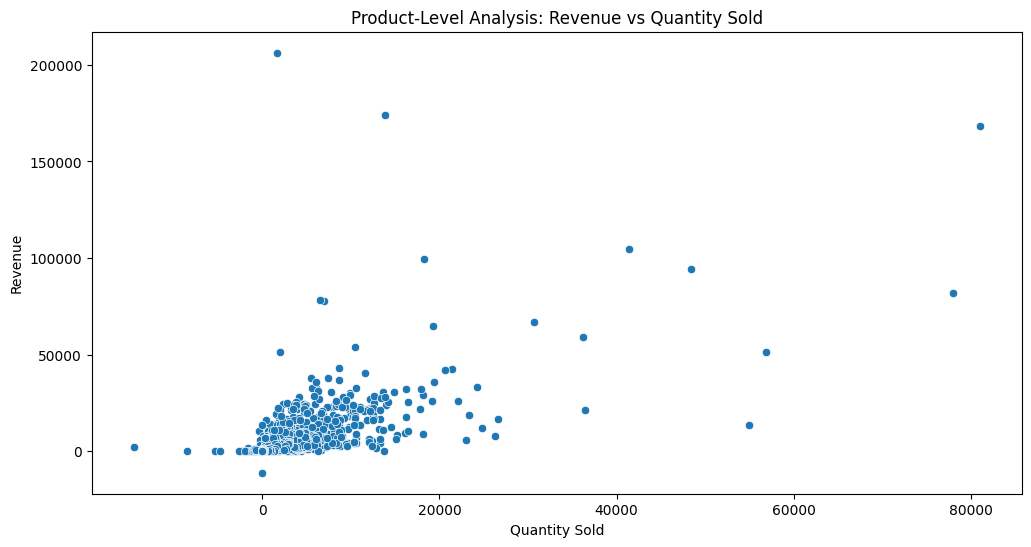

In [34]:
# Question: How do revenue and quantity compare across products?
plt.figure(figsize=(12,6))
sns.scatterplot(data=product_df, x='Quantity', y='Revenue')
plt.title('Product-Level Analysis: Revenue vs Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Revenue')
plt.show()


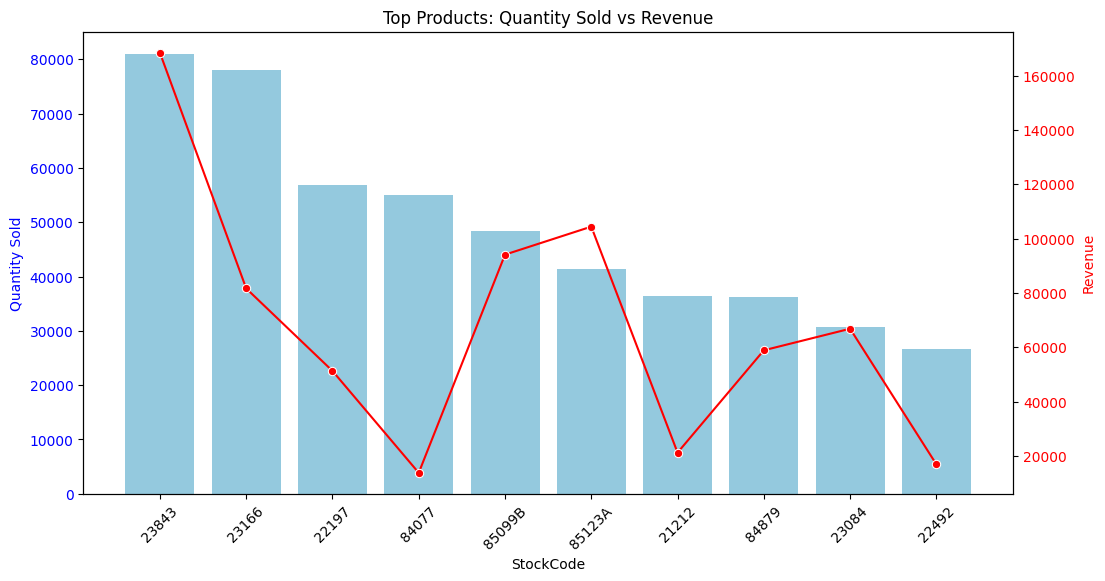

In [ ]:
# Visualize top-selling products and their revenue
fig, ax1 = plt.subplots(figsize=(12,6))

#  Quantity Sold
sns.barplot(data=top_quantity_products, x='StockCode', y='Quantity', color='skyblue', ax=ax1)
ax1.set_ylabel('Quantity Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

# Revenue
ax2 = ax1.twinx()
sns.lineplot(data=top_quantity_products, x='StockCode', y='Revenue', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Revenue', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Top Products: Quantity Sold vs Revenue')
plt.show()


#### Results/Interpretation:

- Majority cluster near the origin: Most products are sold in moderate quantities and generate moderate revenue.
- High-revenue outliers: A few products generate very high revenue even with relatively lower quantity sold — these are premium or high-priced products.
- High-quantity outliers: Some products are sold in large volumes but generate less revenue, indicating low-priced, high-volume items.
- No strict linear correlation: Revenue does not increase proportionally with quantity for all products — shows that both price and volume affect revenue.
- Business insight: Focus marketing, promotions, and inventory management on high-revenue products, while ensuring sufficient stock for high-volume sellers to maintain overall sales.

### 2. Product Seasonality

In [ ]:
# Question: How to calculate monthly sales for each product?
monthly_sales = df.groupby(['StockCode', 'Description', 'Year', 'Month']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

monthly_sales.rename(columns={'TotalPrice': 'Revenue'}, inplace=True)
# Question: Which products show consistent sales growth over months?
# (require more complex time series analysis; placeholder for now)

In [43]:
# Question: Which products should we focus on for seasonality?
top_products = df.groupby(['StockCode', 'Description'])['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_products = top_products.reset_index()

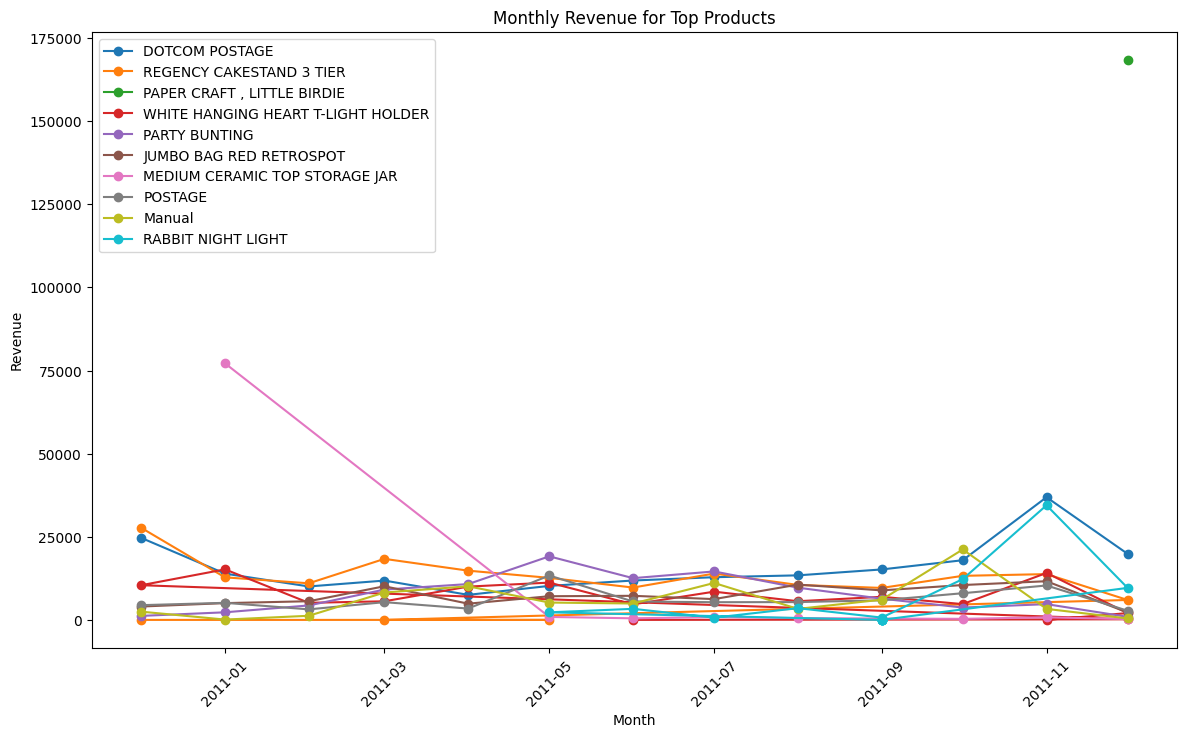

In [49]:
# Revenue-based Seasonality
plt.figure(figsize=(14,8))

for _, row in top_products.iterrows():
    product_data = monthly_sales[(monthly_sales['StockCode'] == row['StockCode'])].copy()
    product_data['YearMonth'] = pd.to_datetime(product_data[['Year','Month']].assign(DAY=1))
    plt.plot(product_data['YearMonth'], product_data['Revenue'], marker='o', label=row['Description'])

plt.title('Monthly Revenue for Top Products')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.show()

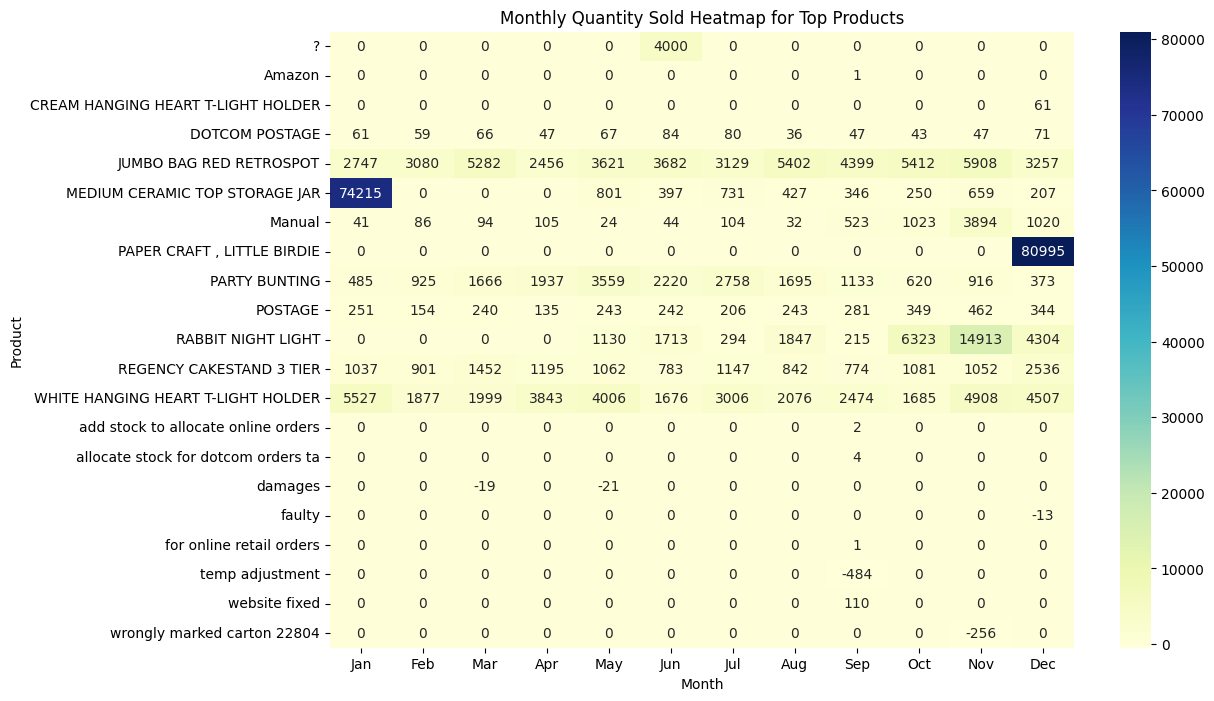

In [54]:
# Question: How to visualize seasonality for top products using a heatmap?

import calendar

heatmap_data = monthly_sales[monthly_sales['StockCode'].isin(top_products['StockCode'])].copy()
heatmap_data['YearMonth'] = pd.to_datetime(heatmap_data[['Year','Month']].assign(DAY=1))

# Sort by YearMonth
heatmap_data = heatmap_data.sort_values('YearMonth')

# Option 1: Monthly heatmap aggregated across years
# Create month abbreviation column
heatmap_data['MonthName'] = heatmap_data['Month'].apply(lambda x: calendar.month_abbr[x])

# Pivot: product as rows, month as columns, sum of quantity
heatmap_pivot = heatmap_data.pivot_table(
    index='Description',
    columns='MonthName',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Ensure months are in calendar order
month_order = [calendar.month_abbr[i] for i in range(1,13)]
heatmap_pivot = heatmap_pivot[month_order]

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Monthly Quantity Sold Heatmap for Top Products')
plt.xlabel('Month')
plt.ylabel('Product')
plt.show()



#### Results/Interpretation:

- Some products are highly seasonal, with sales concentrated in specific months. For example:
     - MEDIUM CERAMIC TOP STORAGE JAR peaks in January.
     - RABBIT NIGHT LIGHT and PAPER CRAFT, LITTLE BIRDIE peak in October–November, showing holiday season demand.
- Products like JUMBO BAG RED RETROSPOT sell consistently throughout the year with minor seasonal spikes.
- Insight: Holiday-season products see a clear increase in demand, highlighting the need for inventory planning and targeted promotions during peak months.